# Entrainement du modèle sur Archive DMS du 01/12/2018 au 30/06/2019

Ce code est le code qui construit le modèle à partir des données obtenues depuis le 01/12/2019, dans une optique de valdiation.
Nous utilisons un XGBoost pour la classification puis performons une analyse SHAP pour analyse du comportement du modèle.

Ce code execute une requête Big Query qui performe plusieurs jointures afin d'obtenir la MasterTable d'entrainement. 
On procède ensuite à une mise en forme des données qui sont fournies ensuite à l'algorithme pour construction du modèle.
Enfin, on analyse les résultats avec un SHAP afin de valider les performances ainsi que le comportement du modèle.

In [1]:
import pandas as pd
import numpy as np
from time import time

import sklearn.metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report

from google.cloud import bigquery

import xgboost as xgb

import matplotlib.pyplot as plt
import collections
import joblib

import scikitplot as skplt

## Load data from Big Query (updated monthly) + Over-sampling

In [2]:
client = bigquery.Client()                     #préparation du client pour interroger BigQuery et garder les data dans un pd.DataFrame

sql5 = """
WITH
  DMS AS (
  SELECT
    ROW_NUMBER() OVER(PARTITION BY date_pr__pa, Code_SAP ORDER BY FLAG_CF ASC) AS ROW,
    FLAG_CF,
    CAST(date_pr__pa AS DATE) AS DATE_PREPA,
    Code_SAP,
    Import_type,
    Usine,
    Base,
    Index_Pareto,
    Cause_Pareto
  FROM
    `electric-armor-213817.Archives_DMS.DMS_2019_07_30`
  GROUP BY
    FLAG_CF,
    date_pr__pa,
    Code_SAP,
    Usine,
    Import_type,
    Base,
    Index_Pareto,
    Cause_Pareto )
  #----------------------------------------------------------------------------
SELECT
  FLAG_CF,
  PREPARATION_DATE,
  PDT_COD,
  PDT_DSC,
IF
  (Forecast_table.Transformable = 'OUI',
    1,
    0) AS TRANSFORMABLE,
  IF(DATE_DIFF( PREPARATION_DATE,CAST(BDD_PDT.Product_launch_date AS DATE), MONTH) < 2 ,1,0) AS INNO,
  IF(Reft = '01 Afh', 1,0) AS IMPLUSE,
  BDD_PDT.Umbrella_Brand,
  DMS.Import_type,
  DMS.Usine,
  PLT_COD,
  PLT_DSC,
  SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code ) AS PREVISION_NATIONAL,
  COMMANDE_NATIONAL,
  ALLOUE_NATIONAL,
  LIVRE_NATIONAL,
  (ALLOUE_NATIONAL - LIVRE_NATIONAL) AS ECART_ALLOC_NATIONAL,
  RUPTURE_NATIONAL,
  RUPTURE_STKA_NATIONAL,
IF
  (SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code ) = 0,
    1,
    0) AS NO_FORECAST_NAT,
  COMMANDE_NATIONAL - SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code ) AS ECART_PREVISION_NAT,
IF
  (SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code ) = 0,
    90000,
    -(SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code ) - COMMANDE_NATIONAL)*100 / SUM(Forecast_table.Forecast_including_adjustments) OVER(PARTITION BY Forecast_table.date, SAP_code )) AS ECART_PREVISION_NAT_PERCENT,
  Forecast_table.Forecast_including_adjustments AS PREVISION,
  COMMANDE,
  ALLOUE,
  LIVRE,
  (ALLOUE - LIVRE) AS ECART_ALLOC,
  RUPTURE,
  RUPTURE_STKA,
IF
  (Forecast_table.Forecast_including_adjustments = 0,
    1,
    0) AS NO_FORECAST,
  COMMANDE - Forecast_table.Forecast_including_adjustments AS ECART_PREVISON,
IF
  (Forecast_table.Forecast_including_adjustments = 0,
    10000,
    -(Forecast_table.Forecast_including_adjustments - COMMANDE)*100 / Forecast_table.Forecast_including_adjustments) AS ECART_PREVISION_PERCENT,
  CSL_ALLOC,
  CSL,
  CSL_ALLOC - CSL AS PERTE_CSL_vs_ALLOC,
  CSL_ALLOC_NATIONAL,
  CSL_NATIONAL,
  CSL_ALLOC_NATIONAL - CSL_NATIONAL AS PERTE_CSL_vs_ALLOC_NATIONAL,
  DMS.Cause_Pareto
FROM
  `electric-armor-213817.Archives_MicroStrategy.CSL_20181201_to_20190630_clean` AS MSTR_Archive_table,
  `electric-armor-213817.Data_Forecasts.Data_Forecasts_CAR` AS Forecast_table,
  `electric-armor-213817.Fichiers_produits.REFERENTIEL_PRODUITS_V2` AS BDD_PDT,
  DMS
WHERE
  MSTR_Archive_table.PREPARATION_DATE = Forecast_table.date
  AND MSTR_Archive_table.PLT_DSC = Forecast_table.DC
  AND MSTR_Archive_table.PDT_COD = Forecast_table.SAP_code
  AND MSTR_Archive_table.PDT_COD = BDD_PDT.Codification
  AND MSTR_Archive_table.PREPARATION_DATE = DMS.DATE_PREPA
  AND MSTR_Archive_table.PDT_COD = DMS.Code_SAP 
  AND IF(DMS.FLAG_CF = 0, TRUE, MSTR_Archive_table.PLT_DSC = DMS.Base)     #Condition sur quelle base joindre dans le cas ou j'ai une CF ou non (car top 10 donné sans la base)


"""

start_time = time()

df = client.query(sql5).to_dataframe()

print('Querying and loading time = {:0.2f} s \n'.format(time() - start_time))


#Regroupement de certaines causes dans la cause 'A Creuser'
df.loc[df['Cause_Pareto'] == 'Schéma', 'Cause_Pareto'] = 'A Creuser'
df.loc[df['Cause_Pareto'] == 'Expe usine', 'Cause_Pareto'] = 'A Creuser'

#Les causes des ruptures CF vont être biaisées car on a récupéré les quantités totales et pas uniquement les quantités de la commande ferme
#df = df[df['FLAG_CF'] == 0]

print('Number of records before deduplication = ',df.shape[0])

#Suppression des doublons
df = df.drop_duplicates(subset=['PREPARATION_DATE','PDT_COD','PLT_COD'], keep = 'first')             #On vire tous les doublons en regardant les colonnes 'date, SAP_code et DC' et on conserve uniquement la première occurence
df = df.dropna() 

print('Number of records after deduplication = ', df.shape[0], '\n')

#------------------- One Hot Encode of categorical data----------------------
data = df.drop(['PREPARATION_DATE', 'PLT_COD', 'PDT_COD', 'PDT_DSC'], axis = 1)

DC = pd.get_dummies(data.PLT_DSC)
PLANT = pd.get_dummies(data.Usine)
#MARQUE = pd.get_dummies(data.Umbrella_Brand)

data = pd.concat([PLANT,DC,data], axis=1)
data = data.drop(['PLT_DSC','Usine','Umbrella_Brand'], axis=1) 


#---------------------- Verification des lignes avec des NULLs--------------------
data.isnull().any().any()


#Séparation des features et target et transformation en ndarray pour passage dans Algo d'oversampling
X = data.iloc[:, :-1].values    #Features
y = data.iloc[:,-1].values      #Labels 

feature_names = list(data)[:-1]
class_names = np.unique(y)

#----------------------Re-sampling ---------------------------------
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

populaire = [list(elem) for elem in collections.Counter(y).most_common()]
max_occurence = int(populaire[0][1])
populaire = pd.DataFrame(columns = ['Class_Name', 'Original_Number'], data = populaire)

max_percent = 0.5

dict_over = {
             'Transport': int(max_occurence*(max_percent-0.02)), 
 #            'Client': int(max_occurence*(max_percent)), 
             'Déploiement/Quarantaine': int(max_occurence*(max_percent-0.25)), 
             'Probleme Copacking': int(max_occurence*(max_percent-0.3)),
             'Production': int(max_occurence*(max_percent+0.2)),
             'Qualité': int(max_occurence*(max_percent+0.05)),
#             'Schéma': int(max_occurence*(max_percent-0.25)),
#             'Expe usine': int(max_occurence*(max_percent-0.3))
            }       #Je crée un dictionnaire ou je lui dit combien de sample je veux par classe 

dict_under = {
#             'A Creuser': int(max_occurence*0.8),
#             'Previsions': int(max_occurence*0.65)
             }

smote = SMOTE(sampling_strategy=dict_over,  k_neighbors=3)
under_sampler = RandomUnderSampler(sampling_strategy = dict_under )

X_SMOTE , y_SMOTE = smote.fit_sample(X,y)
X_SMOTE , y_SMOTE = under_sampler.fit_sample(X_SMOTE , y_SMOTE)

# ----------------- Reconstruction du DataFrame ---------------------
features_df = pd.DataFrame(data = X_SMOTE, columns = feature_names)
target_df = pd.DataFrame(data = y_SMOTE, columns = ['Cause_Pareto'])
data = pd.concat([features_df,target_df], axis=1)

print('DataFrame shape after One Hot Encoding of categorical features and Resampling with SMOTE : ', data.shape)

Querying and loading time = 10.98 s 

Number of records before deduplication =  4253
Number of records after deduplication =  4143 

DataFrame shape after One Hot Encoding of categorical features and Resampling with SMOTE :  (4991, 60)


In [3]:
#-------------------------------------------Feature Engineering ---------------------------------------------------------------------------
#adding of features from combinations of features in the initial dataset



#Put the Class_Name at the end of the DataFrame columns
columns = list(data.columns)
columns.pop(columns.index('Cause_Pareto'))
columns.append('Cause_Pareto')
data = data[columns]


#-----------------------------------Data separation for validation and testing ----------------------------------------------------------
#séparation feature et target_class
X = data.iloc[:, :-1].values    #Inputs
y = data.iloc[:,-1].values      #Output

class_names  = list(set(y))                  #on récupère les noms des classes pour l'analyse SHAP
class_names.sort()                           #on range ces classes par ordre alphabétique

feature_names = list(data)[:-1]              #on récupère les noms des colonnes pour l'analyse SHAP


#test train split
test_fraction = 0.33
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_fraction, random_state=42)




In [4]:
#-----------------------------------Naive hyperparameter tuning of XGB ----------------------------------------------
from time import time

start_time = time()

bst = xgb.XGBClassifier(scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.4,
                      subsample = 1,
                      n_estimators=100, 
                      min_child_weight = 3,
                      reg_alpha = 0.3,
                      max_depth=12, 
                      n_jobs=-1,
                      nthreads = 4,
                      gamma=10)


bst.fit(X_train, y_train)

fitting_time = time()-start_time

print('Total fitting time = {:0.2f}s.'.format(fitting_time))

model = bst


Total fitting time = 4.20s.


In [5]:
#------------------------------------Perform predictions and test model-----------------------------------------------------------
y_predict = model.predict(X_test)
y_predict_proba = model.predict_proba(X_test)

Conf_Matrix = sklearn.metrics.confusion_matrix(y_test, y_predict)
accuracy = sklearn.metrics.accuracy_score(y_predict,y_test)

#print('Confusion Matrix: \n',Conf_Matrix)
print('\nAccuracy = {:0.2f}%.'.format(accuracy*100))

report = classification_report(y_test, y_predict)
print('Classification report on testing dataset: \n',report)


Accuracy = 91.44%.
Classification report on testing dataset: 
                          precision    recall  f1-score   support

              A Creuser       0.93      0.86      0.89       300
                 Client       0.99      0.85      0.92       140
Déploiement/Quarantaine       0.98      0.92      0.95        97
             Previsions       0.85      0.97      0.91       394
     Probleme Copacking       0.73      1.00      0.85        77
             Production       0.96      0.92      0.94       249
                Qualité       0.98      0.89      0.93       208
              Transport       0.94      0.92      0.93       183

               accuracy                           0.91      1648
              macro avg       0.92      0.92      0.91      1648
           weighted avg       0.92      0.91      0.92      1648



In [6]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, nthreads=4, objective='multi:softprob',
              random_state=0, reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)


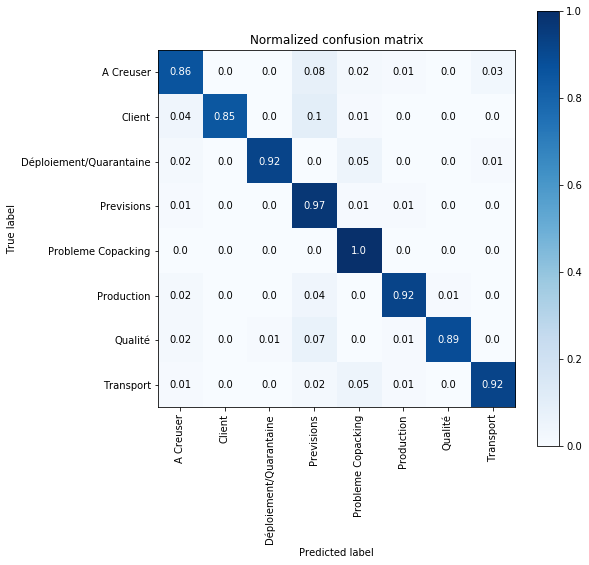

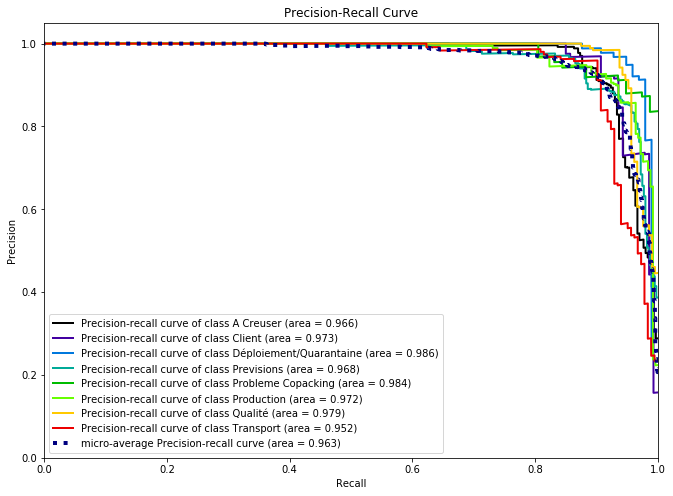

In [7]:
#------------------------ Definition of Model performance Visualization functions ---------------- 
def print_conf_matrix(y_test, y_pred):
    title = 'Normalized confusion matrix'
    ax = skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,title=title, figsize= (8,8), x_tick_rotation = 90)
    return ax

def plot_PRC(y_test, y_probas):
    title = 'Precision-Recall Curve'
    ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(11,8), title = title)
    return ax

def plot_feature_importance(model):
    title = 'Feature Importances'
    ax = skplt.estimators.plot_feature_importances(model,  feature_names=feature_names, x_tick_rotation=90, figsize = (15,5), max_num_features = 100, title = title)
    return ax


print_conf_matrix(y_test, y_predict)
plot_PRC(y_test, y_predict_proba)
#plot_feature_importance(model)

# SHAP Analysis



SHAP feature importance plot for XGB


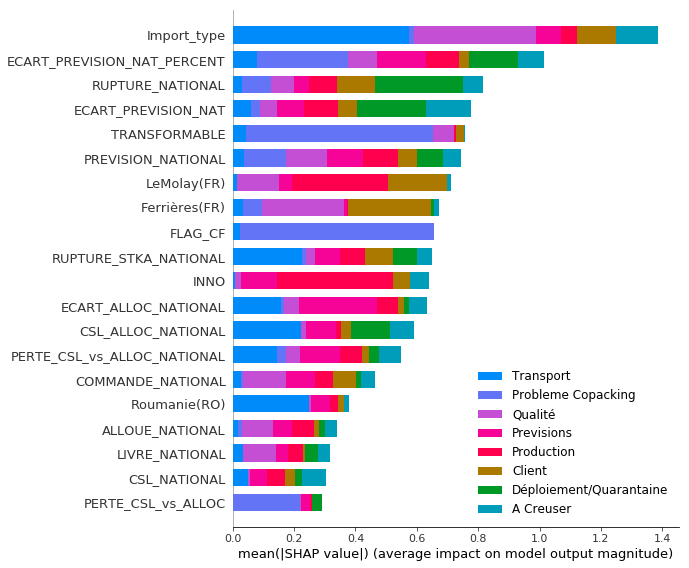


Summary plot for Class: A Creuser


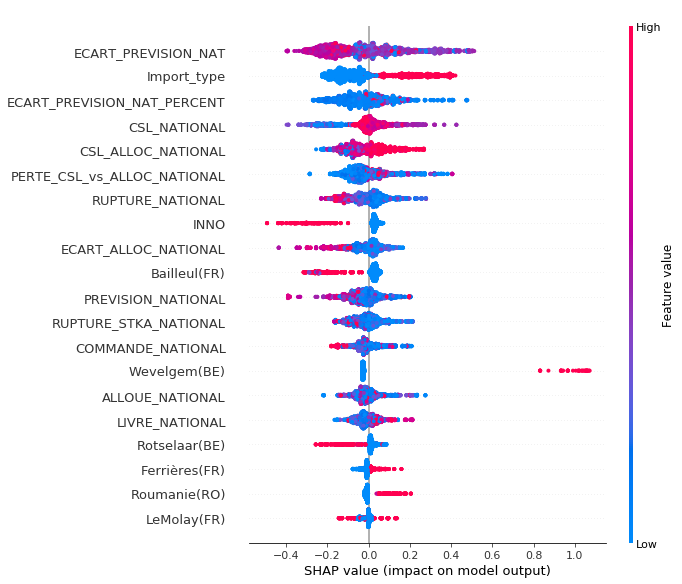


Summary plot for Class: Client


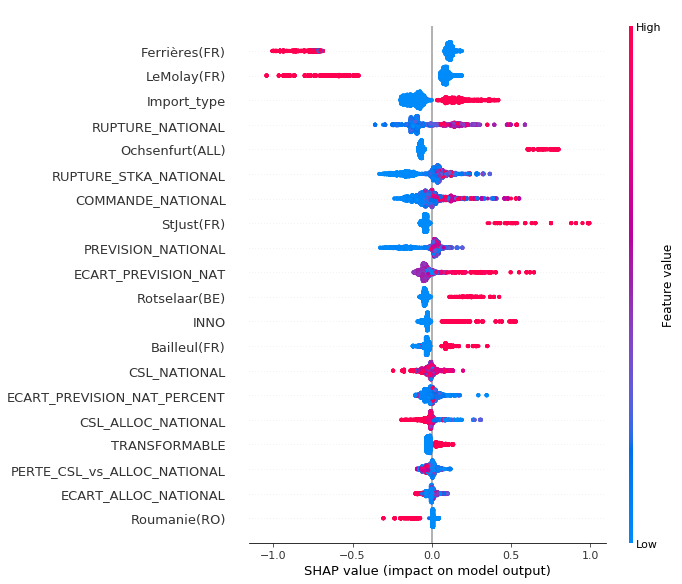


Summary plot for Class: Déploiement/Quarantaine


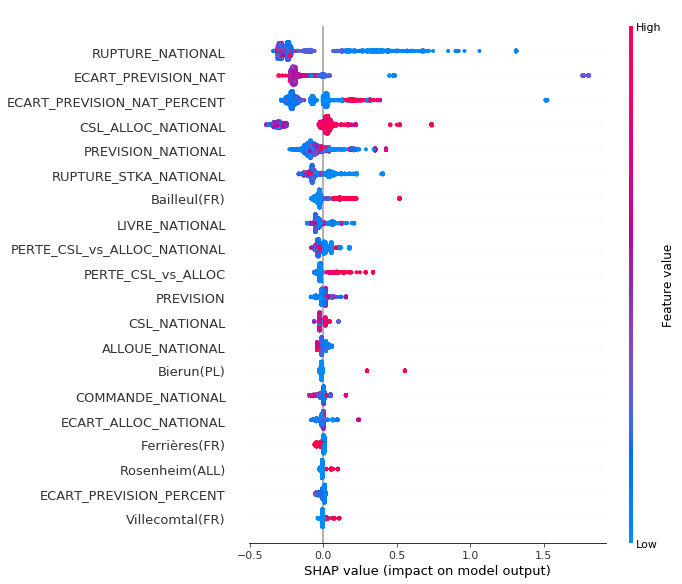


Summary plot for Class: Previsions


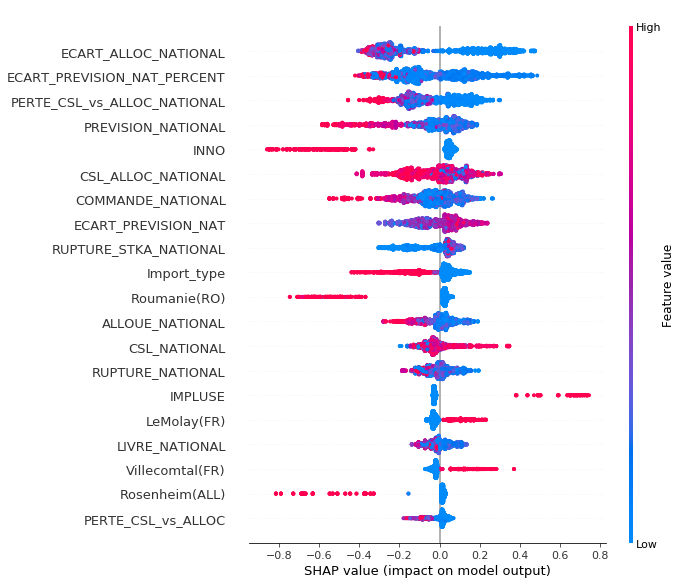


Summary plot for Class: Probleme Copacking


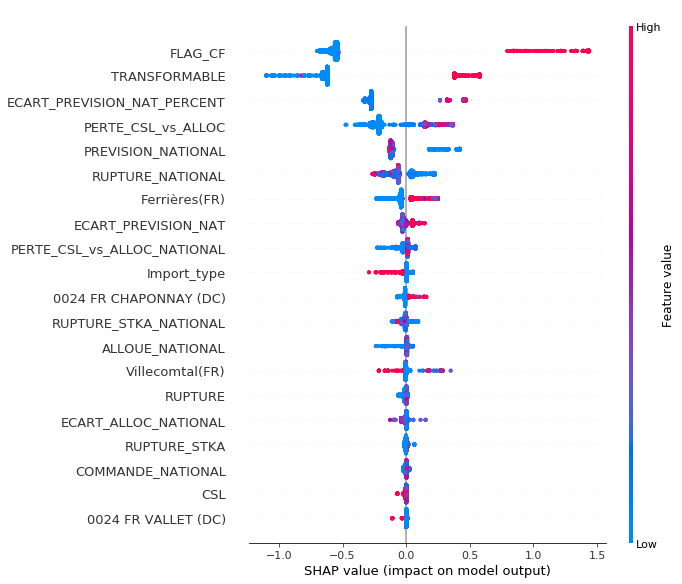


Summary plot for Class: Production


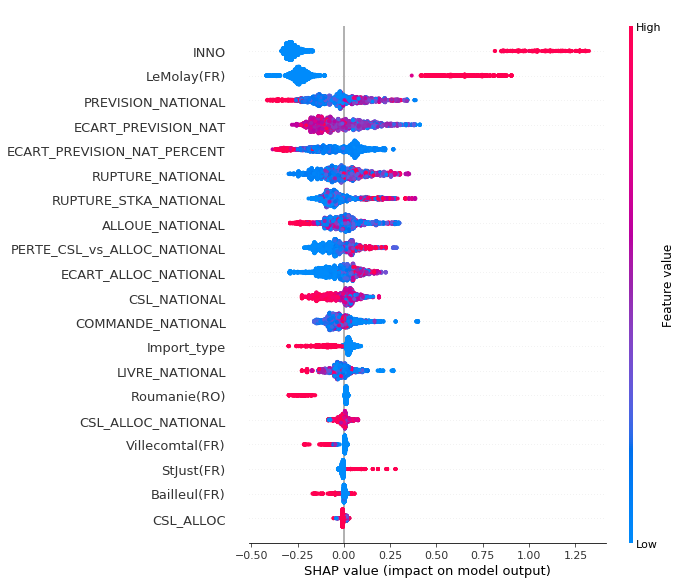


Summary plot for Class: Qualité


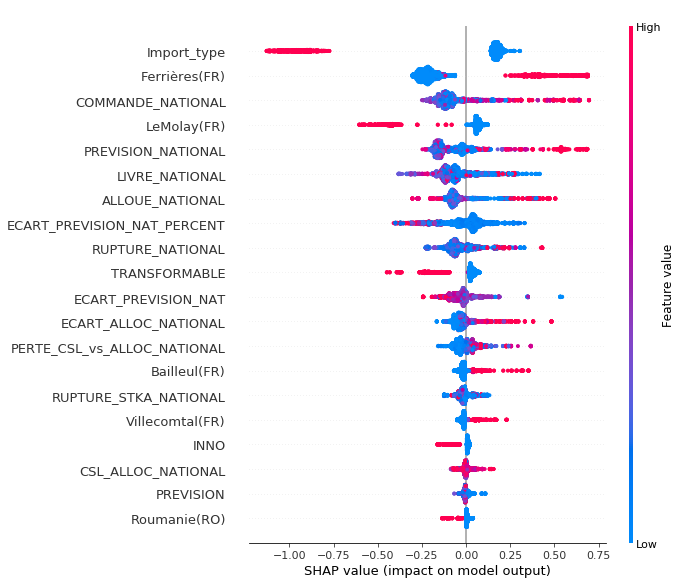


Summary plot for Class: Transport


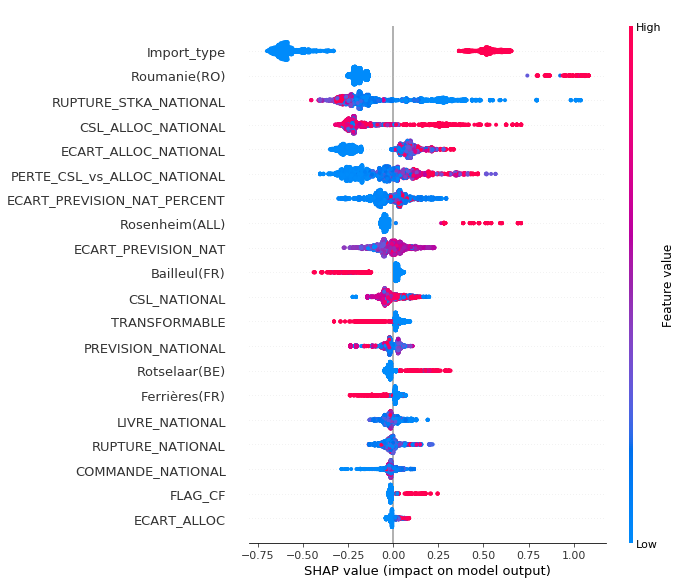

In [9]:
import shap

# load JS visualization code to notebook
shap.initjs()


#Get class labels
X_train = np.array(X_train)
X_test = np.array(X_test)

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
print('\n\nSHAP feature importance plot for XGB')
      
shap.summary_plot(shap_values, X_train, class_names = class_names, feature_names = feature_names, title = 'Random Forest')
for i in range(len(class_names)):
    print('\nSummary plot for Class:',class_names[i])
    shap.summary_plot(shap_values[i], X_train, feature_names = feature_names, title = 'SHAP Analysis for class:' + class_names[i])